/var/folders/cr/71y4sg2s6h3_49cpwstkc5zr0000gn/T/ipykernel_80182/829777784.py:32: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  posts_df = pd.read_csv(POSTS_PATH)


Number of null values in NB_FOLLOWERS: 1218
Remaining rows after dropping null values: 31623
     AUTHORID GEO_ZONE  NB_FOLLOWERS  FASHION_INTEREST_SEGMENT     segment
0    30913535       us        2566.0                     False  Mainstream
1  3725990674       us        2408.0                     False  Mainstream
2  5982278068       us         603.0                     False  Mainstream
3  3657990289       us        1195.0                     False  Mainstream
4   471836256       us        4158.0                     False  Mainstream

=== Segment Statistics ===
           NB_FOLLOWERS                                              
                  count       mean         std      min           max
segment                                                              
Edgy               2388  849641.49  7249907.51  40019.0  2.947181e+08
Mainstream        26681    2041.26     2450.22      0.0  1.199557e+04
Trendy             2554   21126.90     7489.84  12001.0  3.998100e+04

=== Enga

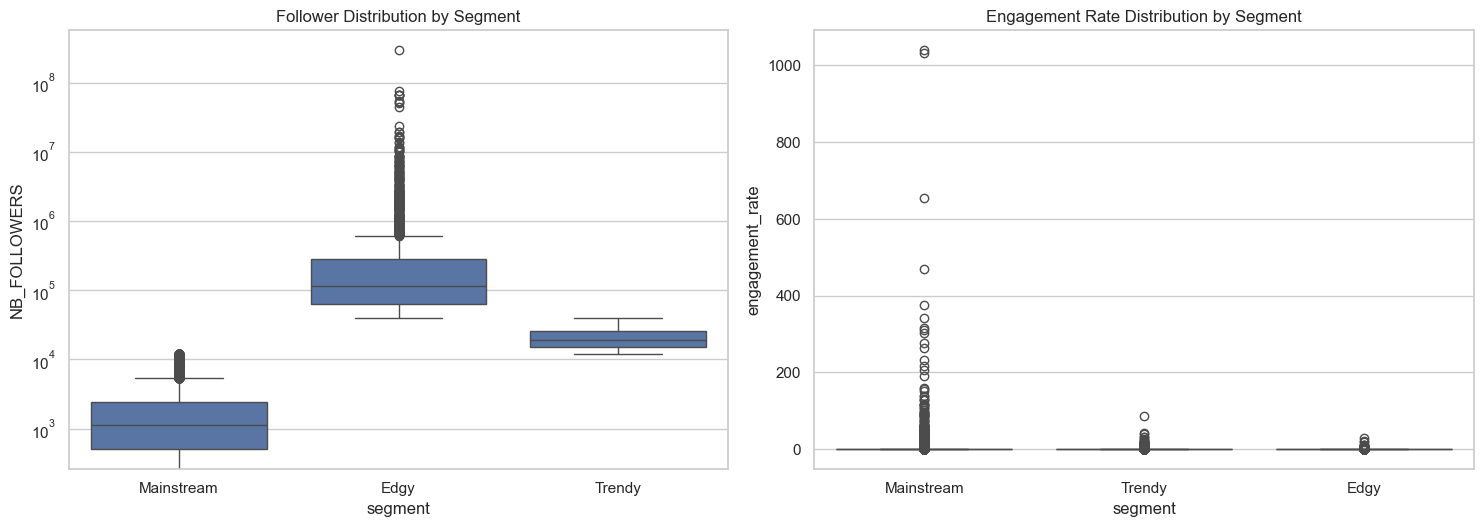

In [12]:
# ---
# Title: Current Segmentation Analysis
# Author: Jinji Shen
# Date: 2025-02-16
# Description:
#   This notebook analyzes the current segmentation methodology based on follower counts.
#   It evaluates segment statistics, engagement metrics, content distribution, and temporal patterns.
# ---

# ### 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set global styles for plots
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

# ### 2. Load Data
# Define paths to data files
DATA_DIR = "/Users/jinjishen/Desktop/my_new_project/heuritech-technical-test/data/raw"
AUTHORS_PATH = f"{DATA_DIR}/MART_AUTHORS.csv"
SEGMENTATIONS_PATH = f"{DATA_DIR}/MART_AUTHORS_SEGMENTATIONS.csv"
LABELS_PATH = f"{DATA_DIR}/MART_IMAGES_LABELS.csv"
POSTS_PATH = f"{DATA_DIR}/MART_IMAGES_OF_POSTS.csv"

# Load datasets
authors_df = pd.read_csv(AUTHORS_PATH)
segmentations_df = pd.read_csv(SEGMENTATIONS_PATH)
labels_df = pd.read_csv(LABELS_PATH)
posts_df = pd.read_csv(POSTS_PATH)

# ### 3. Define Analysis Functions

def analyze_current_segmentation(segmentations_df, posts_df, labels_df):
    """
    Analyze the current segmentation methodology.

    Args:
        segmentations_df (pd.DataFrame): Author segmentation data.
        posts_df (pd.DataFrame): Post engagement data.
        labels_df (pd.DataFrame): Image label data.

    Returns:
        dict: Analysis results including segment stats, engagement metrics, and label distribution.
    """
    # 1. Handle null values in NB_FOLLOWERS
    null_count = segmentations_df['NB_FOLLOWERS'].isnull().sum()
    print(f"Number of null values in NB_FOLLOWERS: {null_count}")
    segmentations_df = segmentations_df.dropna(subset=['NB_FOLLOWERS'])
    print(f"Remaining rows after dropping null values: {len(segmentations_df)}")

    # 2. Assign segments based on follower counts
    def get_segment(followers):
        if followers <= 12000:
            return 'Mainstream'
        elif followers <= 40000:
            return 'Trendy'
        return 'Edgy'

    segmentations_df['NB_FOLLOWERS'] = pd.to_numeric(segmentations_df['NB_FOLLOWERS'], errors='coerce')
    segmentations_df['segment'] = segmentations_df['NB_FOLLOWERS'].apply(get_segment)
    print(segmentations_df.head())


    # 3. Segment statistics
    segment_stats = segmentations_df.groupby('segment').agg({
        'NB_FOLLOWERS': ['count', 'mean', 'std', 'min', 'max']
    }).round(2)

    # 4. Engagement analysis
    posts_df['NB_LIKES'] = pd.to_numeric(posts_df['NB_LIKES'], errors='coerce')
    posts_df['COMMENT_COUNT'] = pd.to_numeric(posts_df['COMMENT_COUNT'], errors='coerce')

    engagement_metrics = posts_df.merge(
        segmentations_df[['AUTHORID', 'segment']],
        on='AUTHORID'
    ).groupby('segment').agg({
        'NB_LIKES': ['mean', 'median', 'std'],
        'COMMENT_COUNT': ['mean', 'median', 'std']
    }).round(2)

    # 5. Engagement rate analysis
    posts_with_followers = posts_df.merge(
        segmentations_df[['AUTHORID', 'NB_FOLLOWERS', 'segment']],
        on='AUTHORID'
    )
    posts_with_followers['engagement_rate'] = np.where(
        posts_with_followers['NB_FOLLOWERS'] > 0,
        posts_with_followers['NB_LIKES'] / posts_with_followers['NB_FOLLOWERS'],
        0
    )
    engagement_rate_stats = posts_with_followers.groupby('segment')['engagement_rate'].agg([
        'mean', 'median', 'std'
    ]).round(4)

    # 6. Content analysis
    if labels_df is not None:
        content_distribution = labels_df.merge(
            posts_df[['IMAGE_ID', 'AUTHORID']],
            on='IMAGE_ID'
        ).merge(
            segmentations_df[['AUTHORID', 'segment']],
            on='AUTHORID'
        )
        label_distribution = content_distribution.groupby(['segment', 'LABEL_NAME']).size().unstack(fill_value=0)
        label_distribution = label_distribution.div(label_distribution.sum(axis=1), axis=0)
    else:
        label_distribution = None

    # 7. Visualization
    plt.figure(figsize=(15, 10))

    # Follower distribution
    plt.subplot(2, 2, 1)
    sns.boxplot(data=segmentations_df, x='segment', y='NB_FOLLOWERS')
    plt.title('Follower Distribution by Segment')
    plt.yscale('log')

    # Engagement rate distribution
    plt.subplot(2, 2, 2)
    sns.boxplot(data=posts_with_followers, x='segment', y='engagement_rate')
    plt.title('Engagement Rate Distribution by Segment')

    plt.tight_layout()
    plt.savefig("/Users/jinjishen/Desktop/my_new_project/heuritech-technical-test/reports/visuals")  # Save plot

    return {
        'segmentations_df': segmentations_df, 
        'segment_stats': segment_stats,
        'engagement_metrics': engagement_metrics,
        'engagement_rate_stats': engagement_rate_stats,
        'label_distribution': label_distribution
    }

# ### 4. Segment Overlap Analysis
def calculate_segment_overlap(segmentations_df):
    """
    Analyze potential overlap between segments
    """
    # Ensure numeric type
    segmentations_df['NB_FOLLOWERS'] = pd.to_numeric(segmentations_df['NB_FOLLOWERS'], errors='coerce')

    # Calculate distance to segment boundaries
    boundaries = [12000, 40000]

    segmentations_df['distance_to_boundary'] = segmentations_df['NB_FOLLOWERS'].apply(
        lambda x: min(abs(x - b) for b in boundaries)
    )

    # Identify accounts near boundaries (within 10%)
    boundary_margin = 0.1
    near_boundary = segmentations_df[
        segmentations_df['distance_to_boundary'] <= segmentations_df['NB_FOLLOWERS'] * boundary_margin
    ]

    return {
        'total_accounts': len(segmentations_df),
        'accounts_near_boundary': len(near_boundary),
        'percentage_near_boundary': (len(near_boundary) / len(segmentations_df)) * 100
    }

# ### 5. Temporal Analysis
def analyze_temporal_patterns(posts_df, segmentations_df):
    """
    Analyze posting patterns and temporal stability
    """
    # Convert to datetime
    posts_df['post_date'] = pd.to_datetime(posts_df['POST_PUBLICATION_DATE'])

    # Merge with author segments
    posts_with_segments = posts_df.merge(
        segmentations_df[['AUTHORID', 'segment']],
        on='AUTHORID'
    )

    # Analyze posting patterns by segment
    posting_patterns = posts_with_segments.groupby(['segment',
                                                  posts_with_segments['post_date'].dt.hour]
                                                 ).size().unstack(fill_value=0)

    # Analyze posting consistency
    posting_consistency = posts_with_segments.groupby('AUTHORID').agg({
        'post_date': lambda x: x.diff().dt.total_seconds().std()  # Standard deviation of time between posts in seconds
    }).merge(segmentations_df[['AUTHORID', 'segment']], on='AUTHORID')

    return {
        'posting_patterns': posting_patterns,
        'posting_consistency': posting_consistency.groupby('segment').mean()
    }

# ### 6. Run Analysis
analysis_results = analyze_current_segmentation(segmentations_df.copy(), posts_df, labels_df)
segmentations_df_modified = analysis_results['segmentations_df']

overlap_results = calculate_segment_overlap(segmentations_df_modified.copy()) 
temporal_results = analyze_temporal_patterns(posts_df, segmentations_df_modified.copy())

# ### 7. Print Results
print("\n=== Segment Statistics ===")
print(analysis_results['segment_stats'])

print("\n=== Engagement Metrics ===")
print(analysis_results['engagement_metrics'])

print("\n=== Engagement Rate Statistics ===")
print(analysis_results['engagement_rate_stats'])

if analysis_results['label_distribution'] is not None:
    print("\n=== Label Distribution ===")
    print(analysis_results['label_distribution'])

print("\n=== Segment Overlap Analysis ===")
print(f"Total accounts: {overlap_results['total_accounts']}")
print(f"Accounts near boundary: {overlap_results['accounts_near_boundary']}")
print(f"Percentage near boundary: {overlap_results['percentage_near_boundary']:.2f}%")

print("\n=== Temporal Patterns ===")
print("Posting Patterns by Hour:")
print(temporal_results['posting_patterns'])
print("\nPosting Consistency (std of time between posts in seconds):")
print(temporal_results['posting_consistency'])